In [ ]:
# default_exp tabular.waterfall

# tabular.waterfall
> This module calculates and plots waterfall chart, this entire module was made by Pavel (Pak)

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastai2.tabular.all import *
from fastinference.tabular.core import *

In [ ]:
#export
from IPython.display import clear_output

In [ ]:
#export
import plotly.graph_objects as go

First let's train a model to analyze

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [ ]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]

In [ ]:
splits = IndexSplitter(list(range(800,1000)))(range_of(df))
to = TabularPandas(df, procs, cat_names, cont_names, y_names="salary", splits=splits)
dls = to.dataloaders()

In [ ]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.379724,0.376351,0.815000,00:04


In [ ]:
#export
class InterpretWaterfall(Interpret):
    def __init__(self, learn, df, fields, sampl_row, max_row_used=None, use_log=False, use_int=False, num_tests=1):
        """
        Calculate all the parameters to plot Waterfall graph for a `sampl_row`
        fields -- list of lists of columns to analyze, connected columns should be in the same list element (as a list)

        max_row_used -- how many rows to use for calculation. len(df) -- by default
            Can be absolute value or coeffficient (from the len(df))
            On big datasets can easily be set to lower values as it's enough data for calculating
            differences anyway. 10k rows is often enough
        num_tests -- id used to reduce memory consumption, each run uses `max_row_used/num_tests` rows, the more
            'num_tests' the less memory consumption is
        use_log=True is needed if we have transformed depended variable into log
        use_int=True is needed if we want to log-detransformed (exponented) var to me integer not float
        """

        super().__init__(learn, df)
        self.fields = fields
        self.sampl_row = sampl_row
        self.use_log = use_log
        self.use_int = use_int
        self.num_tests = num_tests

        if isNone(max_row_used) or (max_row_used > len(df)):
            self.max_row_used = int(len(df) / num_tests)
        elif (max_row_used < 1):
            self.max_row_used = int(len(df) * max_row_used / num_tests)
        else:
            self.max_row_used = int(max_row_used / num_tests)

        print("hold on...")
        self.model_mean = np.array(self.learn.get_preds(dl=self.learn.dls.test_dl(df))[0].T[0]).mean()
        clear_output()
        self.actual = self._predict_row(row=sampl_row)
        self.forces = None
        self.batch_forces = None

        self._calc_forces_repeats()

    def _shuffle_cols(self, sampl_col):
        """
        Returns all the variations of sampl_col columns for a particular row sampl_row.
        (what would be if he had all other values in sampl_col columns)
        Copy all the columns except sampl_col from sampl_row max_row_used times.
        Then add random sampl_col from original distribution
        max_row_used can be < 1, in that case it's a portion of len(df)
        """
        df, learn, sampl_row, max_row_used = self.df, self.learn, self.sampl_row, self.max_row_used

        sampl_col = listify(sampl_col)
        rows = [sampl_row.to_dict()] * max_row_used  # performance optimization
        temp_df = pd.DataFrame(rows)
        shfl_cols = df[sampl_col].sample(max_row_used).copy()
        temp_df[sampl_col] = shfl_cols.values
        return temp_df

    def _calc_forces(self):
        """
        Calculate ordered dict with forces created by certain feature values for particular row
        :return:
        ordered dict of sorted forces
        """
        df, learn, sampl_row, model_mean, fields, max_row_used = self.df, self.learn, self.sampl_row, self.model_mean, self.fields, self.max_row_used

        forces = OrderedDict()
        # build big table with all the variants to check all the data in one run
        huge_df = pd.DataFrame()
        cur_dfs = []
        for field in fields:
            cur_df = self._shuffle_cols(sampl_col=field)
            cur_df['group'] = self._list_to_key(field)
            cur_dfs.append(cur_df)

        huge_df = pd.concat(cur_dfs)
        del cur_dfs

        # predict on it
        huge_df['preds'] = self._predict_df(df=huge_df)
        # predict actual data (just predict sampl_row)
        actual = self._predict_row(row=sampl_row)

        # divide back by fields
        for field in fields:
            cur_df = huge_df.query(f"group == '{self._list_to_key(field)}'")
            # calculate force
            force = float(actual - cur_df['preds'].mean())
            key = f"{field} ({sampl_row[field]})" if isinstance(field, str) else ', '.join(
                f"{e} ({sampl_row[e]})" for e in field)
            forces[key] = force

        self.batch_forces = OrderedDict(sorted(forces.items(), key=lambda kv: abs(kv[1]), reverse=True))

    def _calc_forces_repeats(self):
        """
        Repeat _calc_forces to avg the data and save memory
        """
        num_tests = self.num_tests
        forces = pd.DataFrame()
        for tests in progress_bar(range(num_tests)):
            self._calc_forces()
            forces = forces.append(self.batch_forces, ignore_index=True)
        clear_output()

        forces = forces.mean()
        fc_od = OrderedDict()
        for k, v in forces.iteritems():
            fc_od[k] = v

        self.forces = OrderedDict(sorted(fc_od.items(), key=lambda kv: abs(kv[1]), reverse=True))

    def _conv_exp(self, value, use_log=False, use_int=False):
        """
        Use exponent and convert to integer if needed
        """
        ret_val = value if (use_log == False) else np.exp(value)
        np_int = int if np.isscalar(ret_val) else np.vectorize(np.int)
        ret_val = ret_val if (use_int == False) else np_int(ret_val)
        return ret_val
    
    def _explain_forces(self, forces_show=10):
        """
        :return:
        explained diff (remember 0 expl_diff doent mean no expl in you have 2 explanations with + and -)
        unknown_diff
        """

        def conv_perc(val):
            return (val - 1) * 100

        forces, model_mean, actual, use_log, use_int = self.forces, self.model_mean, self.actual, self.use_log, self.use_int
        expl_diff = np.array(list(forces.values())).sum()
        unk_diff = actual - (model_mean + expl_diff)

        i = 0
        expl_df = pd.DataFrame(columns=['feature', 'coef', 'diff_perc', 'overall_diff', 'overall'])
        # unexplainable value of diff in prices, used in waterfall
        last_price = 0
        price = self._conv_exp(model_mean, use_log=use_log, use_int=use_int)
        expl_df = expl_df.append(pd.DataFrame(
            {'feature': 'model_mean', 'coef': 0, 'diff_perc': 0, 'overall_diff': price - last_price, 'overall': price},
            index=[len(expl_df)]))
        last_price = price
        for key, value in forces.items():
            if (i >= forces_show):
                break
            coef = self._conv_exp(value, use_log=use_log)
            price = int(price * coef) if (use_int == True) else price * (1+coef)
            diff = conv_perc(coef) if (use_int == True) else coef*100
            expl_df = expl_df.append(pd.DataFrame(
                {'feature': key, 'coef': coef, 'diff_perc': diff, 'overall_diff': price - last_price, 'overall': price},
                index=[len(expl_df)]))
            last_price = price
            i += 1
        actl_price = self._conv_exp(actual, use_log=use_log, use_int=use_int)
        coef = actl_price / price
        diff = conv_perc(coef)
        expl_df = expl_df.append(
            pd.DataFrame(
                {
                    'feature': 'others and interconnections', 'coef': coef, 'diff_perc': diff,
                    'overall_diff': actl_price - last_price, 'overall': actl_price
                }, index=[len(expl_df)]
            )
        )

        return expl_df

    def _plot_force_df_coef(self, force_df, name=None):
        """
        Plot forced with coef column (useful in regressions)
        """
        height = max(600, int(len(force_df) / 3 * 100))

        measure = ["relative"] * len(force_df)
        x, text, y = [], [], []
        for i, row in force_df.iterrows():
            y.append(row['feature'][:100])
            text.append(f"{row['overall']} ({row['diff_perc']:+.2f}%)")
            x.append(row['diff_perc'])

        fig = go.Figure(go.Waterfall(
            name="20", orientation="h",
            measure=["relative"] * len(force_df),
            x=x,
            textposition="outside",
            text=text,
            y=y,
            connector={"line": {"color": "rgb(63, 63, 63)"}},
        ))

        title = "Analysis " if isNone(name) else f"Analysis of {name}"
        fig.update_layout(
            title=title,
            showlegend=False,
            height=height,
        )
        fig.update_yaxes(showticklabels=False)

        return fig
    
    
    def _plot_force_df_perc(self, force_df, name=None):
        """
        Plot forced with perc column (useful in classifications)
        """
        height = max(600, int(len(force_df) / 3 * 100))
        x, text, y = [], [], []
        for i, row in force_df.iterrows():
            y.append(row['feature'][:100])
            text.append(f"{row['overall']} ({row['diff_perc']:+.2f}%)")
            x.append(row['overall_diff'])

        fig = go.Figure(go.Waterfall(
            name="20", orientation="h",
            measure=["relative"] * len(force_df),
            x=x,
            textposition="outside",
            text=text,
            y=y,
            connector={"line": {"color": "rgb(63, 63, 63)"}},
        ))

        title = "Analysis " if isNone(name) else f"Analysis of {name}"
        fig.update_layout(
            title=title,
            showlegend=False,
            height=height,
        )
        fig.update_yaxes(showticklabels=False)

        return fig

    def get_forces_fig(self, name=None, forces_show=20):
        """
        Get the force field calculated earlier as plotly figure
        """
        use_log = self.use_log
        df = self._explain_forces(forces_show=forces_show)
        if (use_log == True):
            return self._plot_force_df(force_df=df, name=name)
        else: 
            return self._plot_force_df_perc(force_df=df, name=name)

    def plot_forces(self, name=None, forces_show=20):
        """
        Plot the force field calculated earlier as dynamic json-frame
        """
        fig = self.get_forces_fig(name=name, forces_show=forces_show)
        fig.show()

    def get_forces(self):
        """
        Returns forces as an Ordered Dict
        """
        return self.forces
    
    def get_variants_pd(self, fields):
        """
        returns df with all the values of dep_var for every variant of fields
        helps to determine best value of fields for particular item
        """
        use_log, use_int = self.use_log, self.use_int
        sampl_row = self.sampl_row
        uniqs, variants = self._uniq_cols(sampl_row=sampl_row, fields=fields)
        preds = self._predict_df(df=variants)
        dep_var = self._get_dep_var()
        uniqs[dep_var] = self._conv_exp(value=preds, use_log=use_log, use_int=use_int)
        result = pd.DataFrame([], columns=['feature', dep_var, 'times'])
        for i, row in uniqs.iterrows():
            feats = self._list_to_key(list(row[fields]))
            result = result.append({'feature':feats, dep_var:row[dep_var], 'times':row['counts']}, ignore_index=True)
        return result.sort_values(by=dep_var, ascending=False)
        
    
    def _uniq_cols(self, sampl_row, fields):
        """
        Returns df with all unique values in `fields` other values are copied from `sampl_row`
        """
        df, learn, sampl_row, max_row_used = self.df, self.learn, self.sampl_row, self.max_row_used
        max_rows = int(self.max_row_used*self.num_tests)
        
        uniqs = df.groupby(fields).size().reset_index(name='counts')
        uniqs = uniqs.sort_values(by='counts', ascending=False)
        uniqs = uniqs.head(max_rows)
        
        temp_df = pd.DataFrame([sampl_row.to_dict()] * len(uniqs))
        temp_df[fields] = uniqs[fields].values
        return uniqs, temp_df
    
    def plot_variants(self, fields, limit=20, asc=False):
        """
        Plots how every variant of fields influences dep_var for a particular item
        helps to determine best value of fields for particular column `fields`
        """

        def prepare_colors(df_pd: pd.DataFrame):
            heat_min = df_pd['times'].min()
            heat_max = df_pd['times'].max()
            dif = heat_max - heat_min
            colors = [((times - heat_min) / (dif), (times - heat_min) / (4 * dif), 0.75) for times in df_pd['times']]
            return colors
        use_int = self.use_int
        df = self.get_variants_pd(fields=fields)
        dep_var = self._get_dep_var()

        df['feature'] = df['feature'].str.slice(0, 45)
        df = df.sort_values(by=dep_var, ascending=asc)[:limit].sort_values(by=dep_var, ascending=not (asc))
        colors = prepare_colors(df_pd=df)
        ax = df.plot.barh(x="feature", y=dep_var, sort_columns=True, figsize=(10, 10), color=colors)
        ax.set_ylabel(fields)
        for (p, t) in zip(ax.patches, df['times']):
            frmt = f'{p.get_width():.0f}' if (use_int == True) else f'{p.get_width():.4f}' 
            ax.annotate(frmt, ((p.get_width() * 1.005), p.get_y() * 1.005))
            ax.annotate(f'{int(t)}', ((p.get_width() * .45), p.get_y() + 0.1), color='white', weight='bold')

How does this version calculate each columns part.
- Calculate mean prediction for all the dataset. It will be the starting point for price of an indivilual row to shift from
- For every column calculate the difference between this row prediction and a mean prediction of this column shuffled (how this particular column for a certain values in other columns shifts the dep_var and in what direction)
- Assume that sum of these differences can be transfered as forces onthe first meran predictions
- Plot these forces

>This class allows you to calculate and plot Waterfall graph. Also in can be useful in determining and vizualizing what is the best value of particular feature for a given row of data. 
Calculate all the parameters to plot Waterfall graph for a `sampl_row`
- `fields` 
        list of lists of columns to analyze, connected columns should be in the same list element (as a list)
- `sampl_row`
        row that is analyzed
- `max_row_used`
        how many rows to use for calculation. len(df) -- by default
        Can be absolute value or coeffficient (from the len(df))
        On big datasets can easily be set to lower values as it's enough data for calculating differences anyway. 10k rows is often enough
- `num_tests`
        is used to reduce memory consumption, each run uses `max_row_used/num_tests` rows, the more 'num_tests' the less memory consumption is
- `use_log=True `
        is needed if we have transformed depended variable into log
- `use_int=True` 
        is needed if we want to log-detransformed (exponented) var to me integer not float

In [ ]:
fields = cat_names+cont_names

In [ ]:
cur_item = df.iloc[10]

In [ ]:
cur_item

age                           23
workclass                Private
fnlwgt                    529223
education              Bachelors
education-num                 13
marital-status     Never-married
occupation                   NaN
relationship           Own-child
race                       Black
sex                         Male
capital-gain                   0
capital-loss                   0
hours-per-week                10
native-country     United-States
salary                      <50k
Name: 10, dtype: object

`education` and`education-num` are 100% correlated feature, we totally should group them

In [ ]:
fields = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'age', 'fnlwgt', 'education-num']

In [ ]:
cat_names+cont_names

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'education-num_na',
 'age',
 'fnlwgt',
 'education-num']

In [ ]:
wf = InterpretWaterfall(learn=learn, df=df, fields=fields, 
                        sampl_row=cur_item, max_row_used=0.1)

In [ ]:
wf.get_forces()

OrderedDict([('age (23)', 0.06515264511108398),
             ('relationship ( Own-child)', 0.055278122425079346),
             ('marital-status ( Never-married)', 0.04917985200881958),
             ('occupation (nan)', 0.010632991790771484),
             ('race ( Black)', 0.009711861610412598),
             ('workclass ( Private)', 0.006488978862762451),
             ('fnlwgt (529223)', 0.004645705223083496),
             ('education-num (13.0)', -0.0036606788635253906),
             ('education ( Bachelors)', -0.0036478042602539062)])

In [ ]:
wf.get_forces()

OrderedDict([('marital-status ( Never-married)', 0.1224508285522461),
             ('age (23)', 0.034715473651885986),
             ('relationship ( Own-child)', 0.02508723735809326),
             ('race ( Black)', 0.022664785385131836),
             ('occupation (nan)', 0.005818426609039307),
             ('education-num (13.0)', -0.004229605197906494),
             ('education ( Bachelors)', -0.0018289685249328613),
             ('workclass ( Private)', 0.0007967352867126465),
             ('fnlwgt (529223)', 0.0002853274345397949)])

In [ ]:
wf.plot_forces()

Let's see what ages how affect this particular row

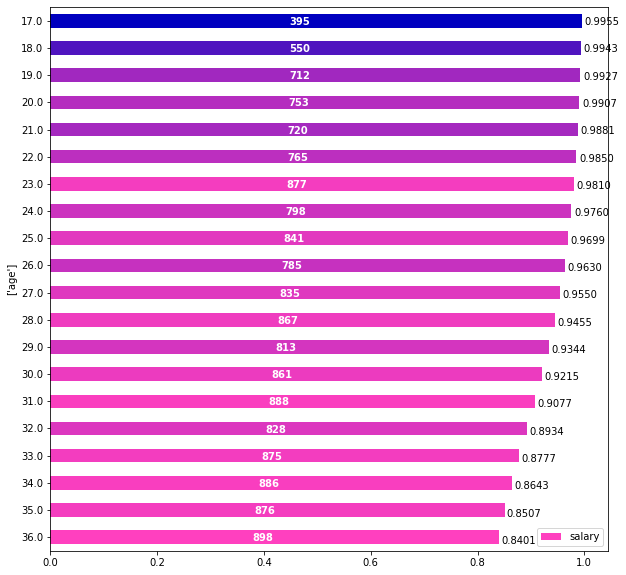

In [ ]:
wf.plot_variants(fields=['age'])

In [ ]:
wf.get_variants_pd(fields=['age'])

NameError: name 'wf' is not defined

Methods exposed: `plot_forces` -- plot waterfall graph calculated in initialization, `get_forces` -- outputs all the forces for a given row as a ordered dict, `plot_variants` -- plot graph of different variants of values of a particular column